In [39]:
import warnings
warnings.filterwarnings('ignore')

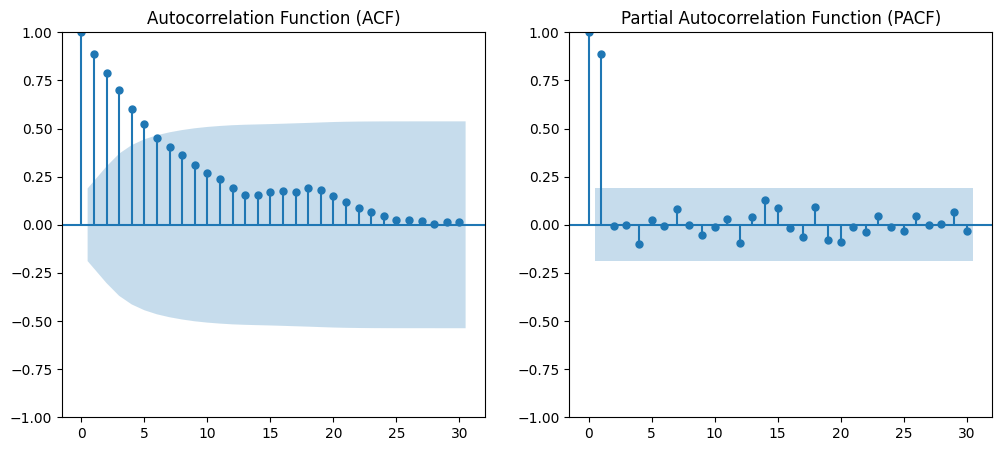

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sample Data (Replace with your dataset)
date_rng = pd.date_range(start='2015-01-01', end='2024-01-01', freq='M')
data = np.cumsum(np.random.randn(len(date_rng)))  # Simulated time series
df = pd.DataFrame({'ds': date_rng, 'y': data})
df.set_index('ds', inplace=True)

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot
plot_acf(df['y'], ax=axes[0], lags=30)  # Adjust lags as needed
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF Plot
plot_pacf(df['y'], ax=axes[1], lags=30, method='ywm')  # Adjust lags as needed
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()


In [41]:
from statsmodels.tsa.stattools import adfuller

# Check Stationarity (ADF Test)
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Time series is non-stationary. Differencing is needed.")
    else:
        print("Time series is stationary.")

check_stationarity(df['y'])

ADF Statistic: -1.6987154514119787
p-value: 0.4317744361884447
Time series is non-stationary. Differencing is needed.


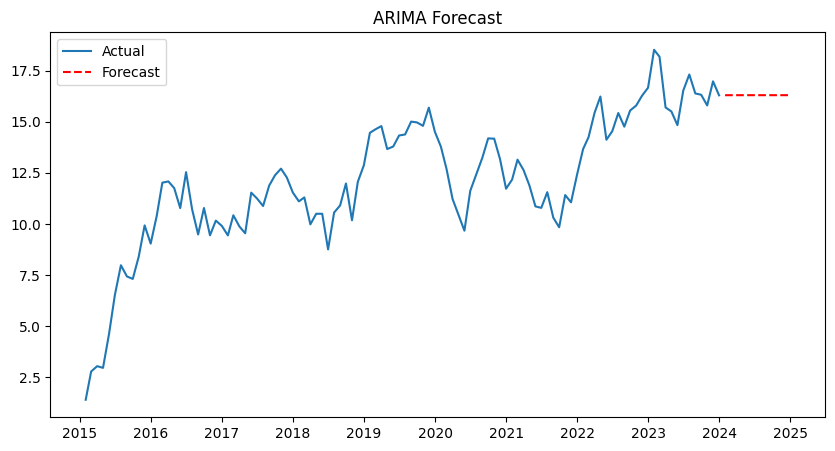

In [61]:
# =========================
# ARIMA MODEL
# =========================
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA Model (p=1, d=1, q=1)
model = ARIMA(df['y'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=12)  # Next 12 months
df_forecast = pd.DataFrame({'ds': pd.date_range(start=df.index[-1], periods=13, freq='M')[1:], 'Forecast': forecast})
df_forecast.set_index('ds', inplace=True)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(df['y'], label='Actual')
plt.plot(df_forecast['Forecast'], label='Forecast', linestyle='dashed', color='red')
plt.title("ARIMA Forecast")
plt.legend()
plt.show()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42431D+00    |proj g|=  2.22541D-01

At iterate    5    f=  1.37430D+00    |proj g|=  1.72340D-02

At iterate   10    f=  1.37260D+00    |proj g|=  2.36483D-03

At iterate   15    f=  1.37233D+00    |proj g|=  1.05253D-02

At iterate   20    f=  1.36996D+00    |proj g|=  1.66453D-02

At iterate   25    f=  1.36903D+00    |proj g|=  2.30229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   

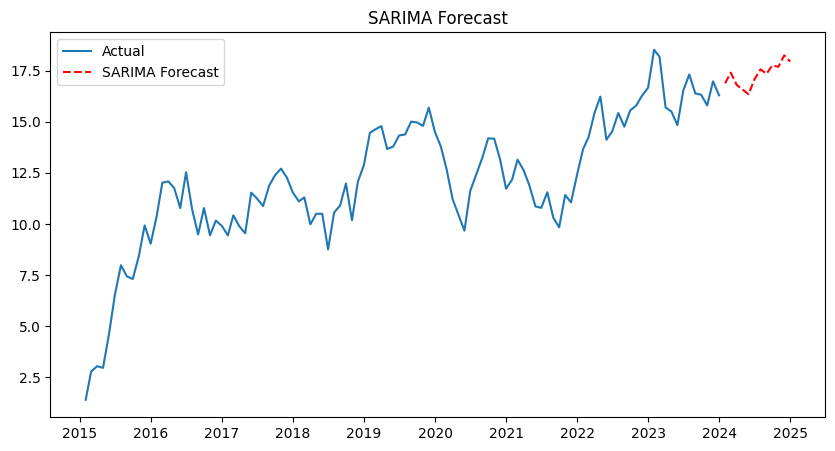

In [62]:
# =========================
# SARIMA MODEL (Seasonal ARIMA)
# =========================
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA Model (p=1, d=1, q=1) and (P=1, D=1, Q=1, S=12 for monthly seasonality)
model_sarima = SARIMAX(df['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

# Forecast
forecast_sarima = model_sarima_fit.forecast(steps=12)
df_forecast_sarima = pd.DataFrame({'ds': pd.date_range(start=df.index[-1], periods=13, freq='M')[1:], 'Forecast': forecast_sarima})
df_forecast_sarima.set_index('ds', inplace=True)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(df['y'], label='Actual')
plt.plot(df_forecast_sarima['Forecast'], label='SARIMA Forecast', linestyle='dashed', color='red')
plt.title("SARIMA Forecast")
plt.legend()
plt.show()



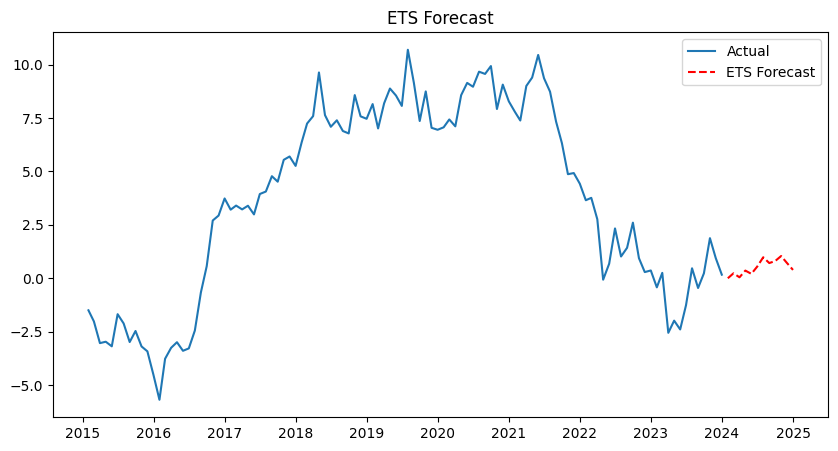

In [44]:
# =========================
# EXPONENTIAL SMOOTHING (ETS)
# =========================
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_ets = ExponentialSmoothing(df['y'], trend="add", seasonal="add", seasonal_periods=12)
model_ets_fit = model_ets.fit()
forecast_ets = model_ets_fit.forecast(steps=12)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(df['y'], label='Actual')
plt.plot(forecast_ets, label='ETS Forecast', linestyle='dashed', color='red')
plt.title("ETS Forecast")
plt.legend()
plt.show()

00:15:16 - cmdstanpy - INFO - Chain [1] start processing
00:15:16 - cmdstanpy - INFO - Chain [1] done processing


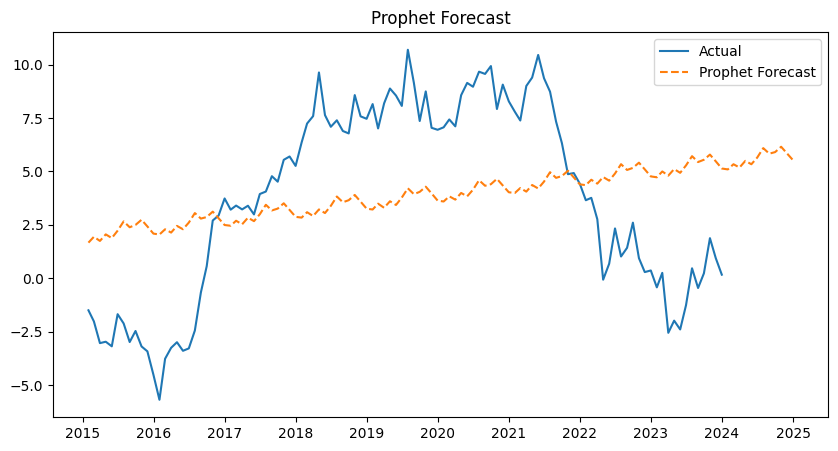

In [45]:
# =========================
# PROPHET MODEL
# =========================
from prophet import Prophet


df_prophet = df.reset_index()
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=12, freq='M')
forecast_prophet = model_prophet.predict(future)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(df['y'], label='Actual')
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label="Prophet Forecast", linestyle='dashed')
plt.title("Prophet Forecast")
plt.legend()
plt.show()

ARIMA RMSE: 1.9063
ARIMA MAPE: 9.7337%


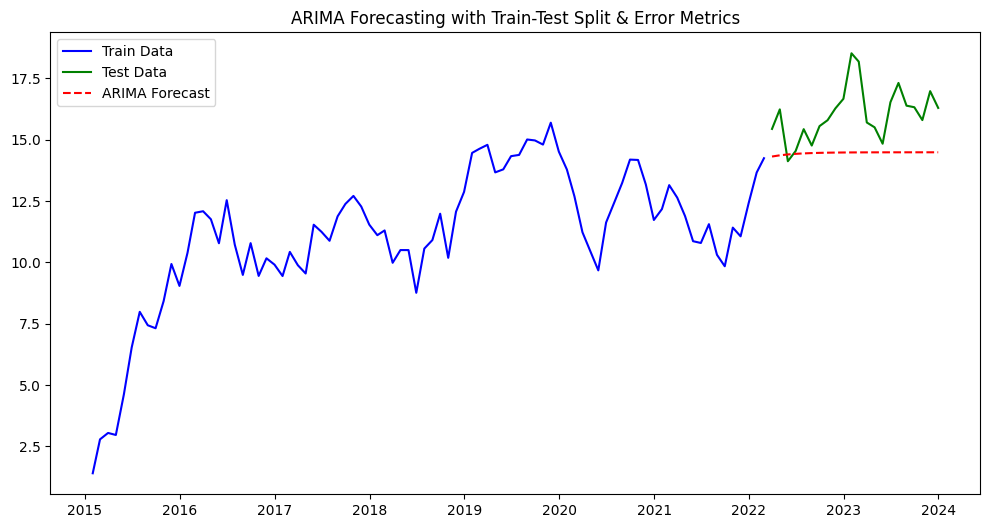

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# =========================
# Train-Test Split
# =========================
split_ratio = 0.8  # 80% Train, 20% Test
split_index = int(len(df) * split_ratio)

train = df.iloc[:split_index]
test = df.iloc[split_index:]

# =========================
# ARIMA MODEL TRAINING
# =========================
model_arima = ARIMA(train['y'], order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# Forecast on Test Set
forecast_steps = len(test)
forecast_arima = model_arima_fit.forecast(steps=forecast_steps)

# =========================
# Calculate Performance Metrics
# =========================
rmse_arima = np.sqrt(mean_squared_error(test['y'], forecast_arima))
mape_arima = mean_absolute_percentage_error(test['y'], forecast_arima)

print(f"ARIMA RMSE: {rmse_arima:.4f}")
print(f"ARIMA MAPE: {mape_arima:.4%}")


# =========================
# PLOT RESULTS
# =========================
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['y'], label="Train Data", color='blue')

# Plot test data
plt.plot(test.index, test['y'], label="Test Data", color='green')

# Plot ARIMA Forecast
plt.plot(test.index, forecast_arima, label="ARIMA Forecast", linestyle='dashed', color='red')

# Labels & Legend
plt.title("ARIMA Forecasting with Train-Test Split & Error Metrics")
plt.legend()
plt.show()


INVALID COMBINATION 9 9 1
Best ARIMA Params: (9, 2, 7) with RMSE: 1.0289
All Results: {(0, 0, 0): {'RMSE': 5.057243245712058, 'MAPE': 0.30503122587412546}, (0, 0, 1): {'RMSE': 5.031103181248591, 'MAPE': 0.30162353021992044}, (0, 0, 2): {'RMSE': 5.057991281365057, 'MAPE': 0.3036248291980402}, (0, 0, 3): {'RMSE': 5.014272583737864, 'MAPE': 0.29762089076619463}, (0, 0, 4): {'RMSE': 5.020088847715668, 'MAPE': 0.29768760811386547}, (0, 0, 5): {'RMSE': 4.951396600774456, 'MAPE': 0.28809237439962093}, (0, 0, 6): {'RMSE': 4.865069832282027, 'MAPE': 0.27744378531557995}, (0, 0, 7): {'RMSE': 5.063228594755588, 'MAPE': 0.29409889997421457}, (0, 0, 8): {'RMSE': 4.91636755735557, 'MAPE': 0.2806515250602192}, (0, 0, 9): {'RMSE': 4.7968648447701625, 'MAPE': 0.265745672834231}, (0, 1, 0): {'RMSE': 2.0972739893266463, 'MAPE': 0.10968602225183392}, (0, 1, 1): {'RMSE': 2.093840829567548, 'MAPE': 0.10946263678746432}, (0, 1, 2): {'RMSE': 2.0844002883691966, 'MAPE': 0.10885243362110307}, (0, 1, 3): {'RMSE'

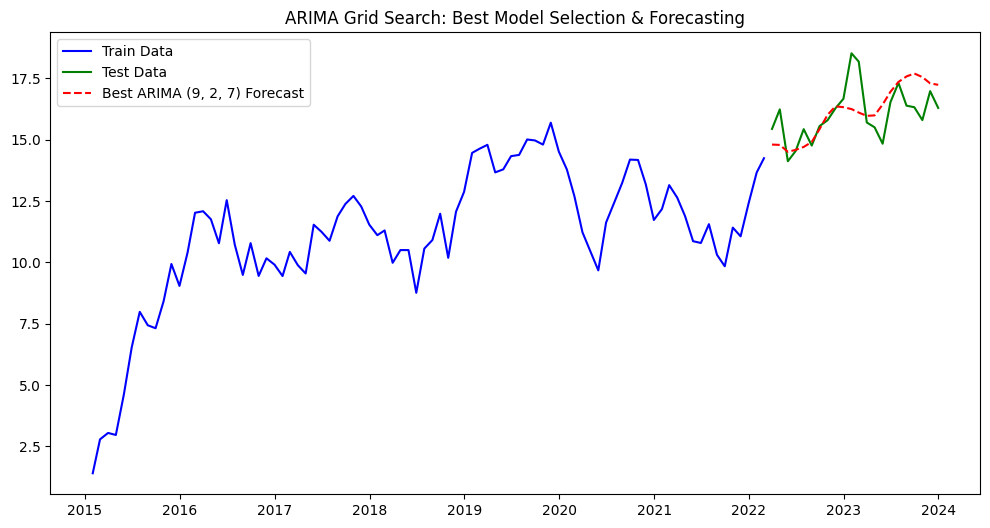

In [70]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# =========================
# Train-Test Split
# =========================
split_ratio = 0.8  # 80% Train, 20% Test
split_index = int(len(df) * split_ratio)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

# =========================
# Hyperparameter Grid Search for ARIMA
# =========================
p_values = range(0, 10)  # Possible AR values
d_values = range(0, 10)  # Possible Differencing values
q_values = range(0, 10)  # Possible MA values

best_score = float("inf")
best_params = None
results_dict = {}

number_of_loops = 0
for p, d, q in itertools.product(p_values, d_values, q_values):
    number_of_loops +=1
    try:
        model = ARIMA(train['y'], order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))

        # Calculate error metrics
        rmse = np.sqrt(mean_squared_error(test['y'], forecast))
        mape = mean_absolute_percentage_error(test['y'], forecast)

        # Store results in a dictionary
        results_dict[(p, d, q)] = {'RMSE': rmse, 'MAPE': mape}

        # Keep track of the best parameters
        if rmse < best_score:
            best_score = rmse
            best_params = (p, d, q)
    except:
        print("INVALID COMBINATION", p,d,q)
        continue  # Skip invalid parameter combinations

# =========================
# Best Model & Results
# =========================
print(f"Best ARIMA Params: {best_params} with RMSE: {best_score:.4f}")
print("All Results:", results_dict)

# =========================
# Train Final Model with Best Params
# =========================
best_model = ARIMA(train['y'], order=best_params)
best_model_fit = best_model.fit()
best_forecast = best_model_fit.forecast(steps=len(test))


# =========================
# PLOT RESULTS
# =========================
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train['y'], label="Train Data", color='blue')

# Plot test data
plt.plot(test.index, test['y'], label="Test Data", color='green')

# Plot Best ARIMA Forecast
plt.plot(test.index, best_forecast, label=f"Best ARIMA {best_params} Forecast", linestyle='dashed', color='red')

# Labels & Legend
plt.title("ARIMA Grid Search: Best Model Selection & Forecasting")
plt.legend()
plt.show()


In [71]:
number_of_loops

1000